In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/EE-519/MP2

import time
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import models, transforms, utils
from torchvision.transforms.functional import to_pil_image
from torch.autograd import Variable
from IPython import display


Mounted at /content/drive
/content/drive/MyDrive/EE-519/MP2


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for i, (X, y) in enumerate(dataloader):
        y = y.type(torch.int64)
        X = X.to(device)
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return(loss_fn(pred, y).item())
    

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.type(torch.int64)
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, 100*correct

In [ ]:
# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 10
EPOCHS = 100

# define the train and val splits
TRAIN_SPLIT = 0.8
VAL_SPLIT = 1 - TRAIN_SPLIT

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Open training data and load
file = h5py.File("DEM_train.h5", "r+")
X_train = np.array(file["/images"])
y_train = np.array(file["/meta"])
file.close()
X_train = X_train[:,None,:,:]
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)

# Open test data and load
file = h5py.File("DEM_test_features.h5", "r+")
X_test = np.array(file["/images"])
X_test = X_test[:,None,:,:]
X_test = torch.tensor(X_test)
file.close()

#classify the y values
for i in range(len(y_train)):
    if y_train[i] <= 25:
        y_train[i] = 0
    elif y_train[i] <= 50:
        y_train[i] = 1
    elif y_train[i] <= 200:
        y_train[i] = 2
    else:
        y_train[i] = 3

#apply transform to data
transform1 = transforms.Compose([
    #transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(0.95)
])
#scripted_transform = torch.jit.script(transform1)
X_train_random = transform1(X_train)


#concatenate new data and original
X_train = torch.cat((X_train, X_train_random))
y_train = torch.cat((y_train, y_train))


class ImageDataset:
    def __init__(self, images, labels):
        self.y = torch.tensor(np.float32(labels))
        self.X = torch.tensor(np.float32(images))
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index, :, :, :], self.y[index]

dataset = ImageDataset(X_train, y_train)

numTrainSamples = math.ceil(len(dataset) * TRAIN_SPLIT)
numValSamples = int(len(dataset) * VAL_SPLIT)

(train_set, val_set) = torch.utils.data.random_split(dataset,
    [numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))


#create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = BATCH_SIZE,
    shuffle = True)

val_dataloader = torch.utils.data.DataLoader(
    dataset = val_set,
    batch_size = BATCH_SIZE,
    shuffle = True)


In [ ]:
def nin_block(out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(out_channels, kernel_size=1), 
        #batch normalization implementation
        nn.LazyBatchNorm2d(),
        nn.ReLU())

class model(nn.Module):
    def __init__(self, lr=0.01, num_classes=4):
        super().__init__()
        #self.save_hyperparameters()
        self.net = nn.Sequential(
            nin_block(96, kernel_size=5, strides=3, padding=0),
            nn.MaxPool2d(3, stride=2),
            nin_block(256, kernel_size=3, strides=1, padding=2),
            nn.MaxPool2d(3, stride=2),
            nin_block(384, kernel_size=3, strides=1, padding=1),
            nn.MaxPool2d(3, stride=2),
            #nn.Dropout(0.5),
            nin_block(num_classes, kernel_size=3, strides=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten())

        
    def forward(self, x):
        return self.net(x)

def init_weights(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)


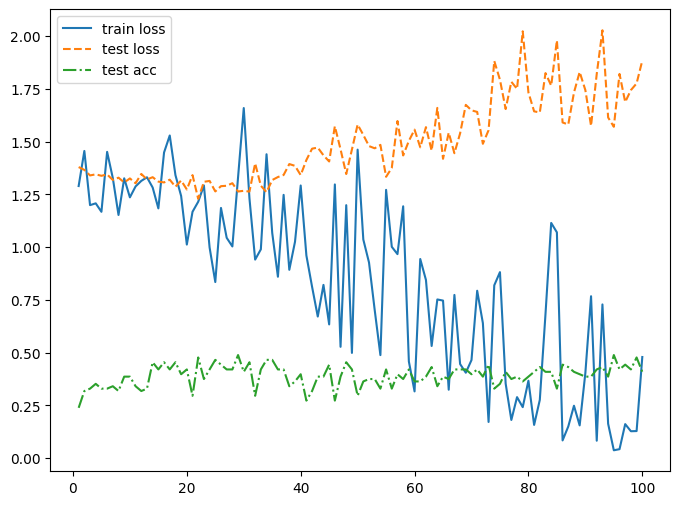

Final Accuracy: 40.9%


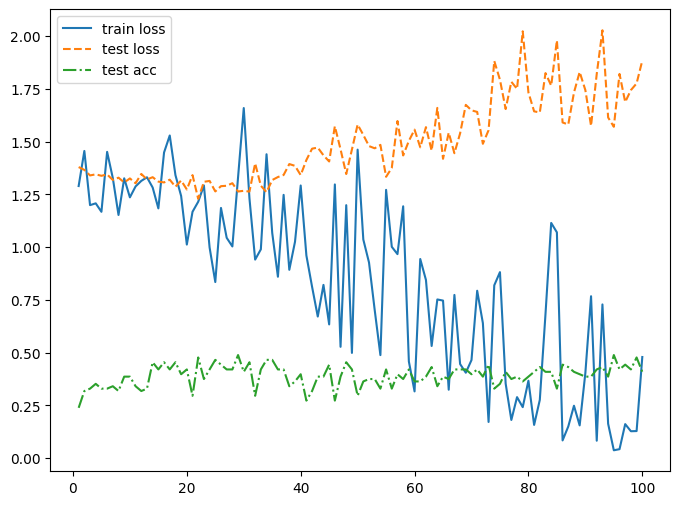

In [ ]:
model = model(lr=INIT_LR).to(device)

# initialize weights, requires forward pass for Lazy layers
X = next(iter(train_dataloader))[0].to(device)    # get a batch from dataloader
model.forward(X)                       # apply forward pass
model.apply(init_weights)              # apply initialization

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


plt.figure(figsize=(8,6))
train_losses = []
test_losses = []
test_accs = []
for t in range(EPOCHS):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(val_dataloader, model, loss_fn)
    
    # plot
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    test_accs.append(test_acc/100)
    plt.clf()
    plt.plot(np.arange(1, t+2), train_losses, '-', label='train loss')
    plt.plot(np.arange(1, t+2), test_losses, '--', label='test loss')
    plt.plot(np.arange(1, t+2), test_accs, '-.', label='test acc')
    plt.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.0001)
    
print(f"Final Accuracy: {(test_acc):>0.1f}%")

save_path = 'model.pth'
torch.save(model.state_dict(), save_path)